### Code to demonstrate how marine heatwaves are defined using the NOAA Optimum Interpolation Sea Surface Temperature v2.1 dataset.

- Data is available [here](https://www.ncdc.noaa.gov/oisst/optimum-interpolation-sea-surface-temperature-oisst-v21).

In [274]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from matplotlib.animation import FFMpegWriter
from matplotlib import animation, rc
from IPython.display import HTML

Load dataset

In [2]:
# Load dataset
ds = xr.open_mfdataset('/glade/scratch/scanh/OISST/v2.1/oisst-avhrr-v02r01.*.nc', decode_times=True, combine='by_coords')

In [3]:
# Calculate monthly mean SST
da = ds.sst.squeeze().resample(time='MS').mean().squeeze()
da.load();

/glade/u/home/scanh/miniconda3/envs/marine-heatwaves/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [4]:
years = pd.DatetimeIndex(da.time.values).year
months = pd.DatetimeIndex(da.time.values).month

dyr = []
for i in enumerate(years):
    I = i[1] + ((months[i[0]]-0.5)/12) 
    dyr.append(I)
dyr = np.array(dyr)

Pick a point of interest

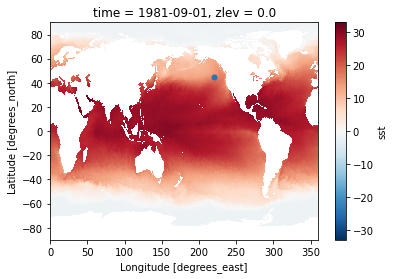

In [5]:
da[0,:,:].plot()
plt.plot(da.lon.sel(lon=220.125), da.lat.sel(lat=45.125), '.', ms=10)

In [6]:
sst = da.sel(lon=220.125, lat=45.125)

Fit mean, trend, annual, and semi-annual harmonics to SST over entire record¶

In [314]:
# Our 6 coefficient model is composed of the mean, trend, annual sine and cosine harmonics, & semi-annual sine and cosine harmonics
model = np.array([np.ones(len(dyr))] + [dyr-np.mean(dyr)] + [np.sin(2*np.pi*dyr)] + [np.cos(2*np.pi*dyr)] + [np.sin(4*np.pi*dyr)] + [np.cos(4*np.pi*dyr)])

# Take the pseudo-inverse of model to 'solve' least-squares problem
pmodel = np.linalg.pinv(model)

# Convert model and pmodel to xaray DataArray
model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':sst.time.values, 'coeff':np.arange(1,7,1)}) 
pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':np.arange(1,7,1), 'time':sst.time.values})  

# resulting coefficients of the model
sst_mod = xr.DataArray(pmodel_da.dot(sst), dims=['coeff'], coords={'coeff':np.arange(1,7,1)})  

# Construction of the mean, trend, and seasonal cycle
mean = xr.DataArray(model_da[:,0].dot(sst_mod[0]), dims=['time'], coords={'time':sst.time})   
trend = xr.DataArray(model_da[:,1].dot(sst_mod[1]), dims=['time'], coords={'time':sst.time})    
seas = xr.DataArray(model_da[:,2:].dot(sst_mod[2:,]), dims=['time'], coords={'time':sst.time})


Compute SST anomalies

In [315]:
# compute anomalies (SSTa) by removing model coefficients – with and without the trend
ssta_notrend = xr.DataArray((sst.values-model_da.dot(sst_mod)).values, dims=['time'], coords={'time':sst.time}) 
ssta_trend = xr.DataArray((sst.values-model_da.dot(sst_mod[[0,2,3,4,5]])).values, dims=['time'], coords={'time':sst.time})

Pick threshold for marine heatwaves (we will use the 90th percentile of the SST anomalies)

In [316]:
# Define extreme threshold as the 90th percentile
thresh = .9

# Compute values of the monthly threshold
prct_notrend = ssta_notrend.quantile(thresh, dim='time', skipna=True)
prct_trend = ssta_trend.quantile(thresh, dim='time', skipna=True)

Find where SST anomalies exceed this threshold

In [317]:
# Take only the SSTa that exceeds the calculated monthly threshold
mhw_ssta_notrend = ssta_notrend.where(ssta_notrend>prct_notrend)
mhw_ssta_trend = ssta_trend.where(ssta_trend>prct_trend)

Plot the SST time series

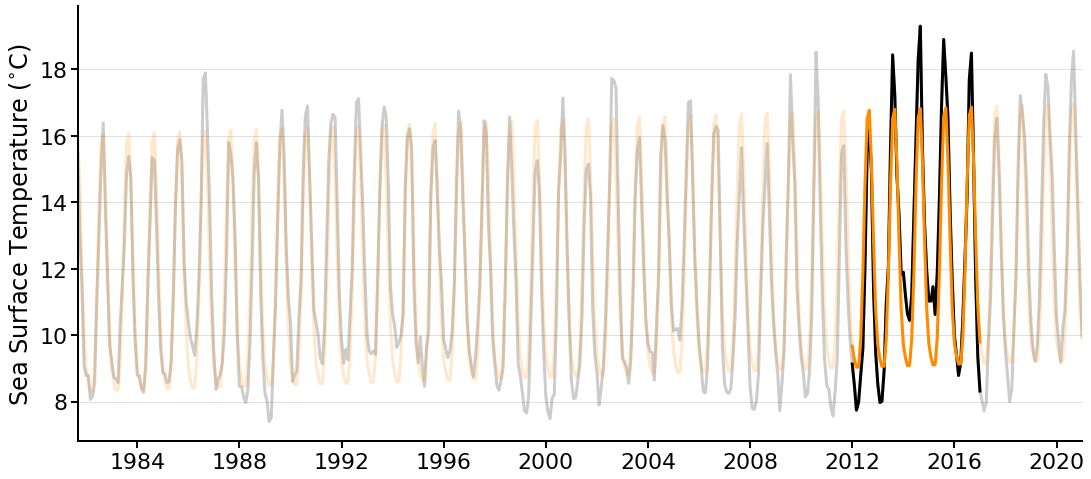

In [323]:
fit = seas+mean+trend

plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.rcParams['axes.linewidth'] = 2


fig = plt.figure(figsize=(18,8)) 
ax = plt.subplot(111)
ax.plot(sst.time, sst, '-k', linewidth=3, alpha=0.2)
ax.plot(sst.time, fit, '-', color='darkorange', linewidth=3, alpha=0.2)

ax.plot(sst.time.sel(time=slice('2012-01-01', '2017-01-01')), sst.sel(time=slice('2012-01-01', '2017-01-01')), '-k', linewidth=3)
ax.plot(sst.time.sel(time=slice('2012-01-01', '2017-01-01')), fit.sel(time=slice('2012-01-01', '2017-01-01')), '-', color='darkorange', linewidth=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(which='major', width=2, length=7)
ax.tick_params(which='minor', width=1, length=4)
plt.xlim(sst.time[0].values, sst.time[-1].values)
ax.yaxis.grid(alpha=0.5)
plt.ylabel(r'Sea Surface Temperature ($ \rm ^{\circ} C$)', fontsize=24);

Plot long time series of anomalies

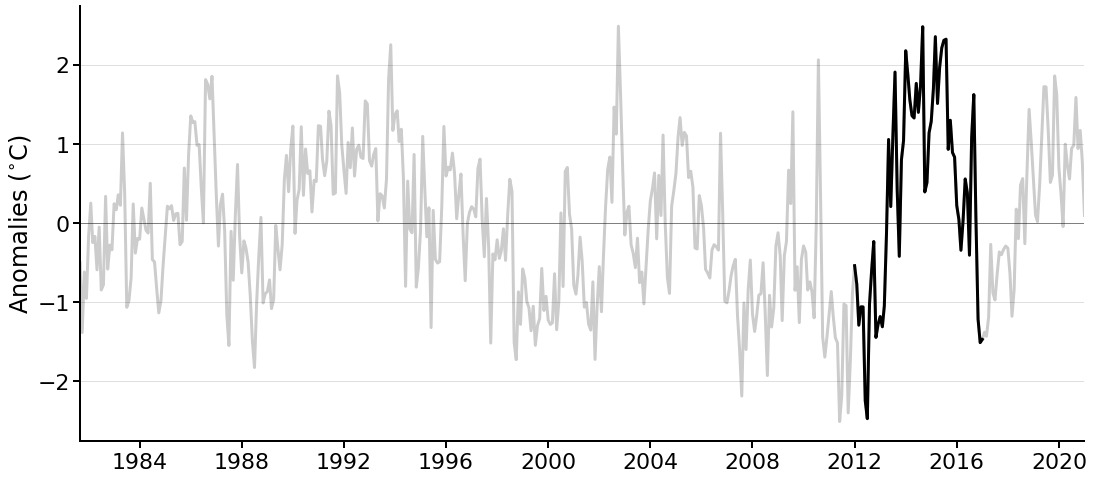

In [326]:

plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.rcParams['axes.linewidth'] = 2


fig = plt.figure(figsize=(18,8)) 
ax = plt.subplot(111)
ax.axhline(0, color='grey', linewidth=1)
ax.plot(ssta_notrend.time, ssta_notrend, '-', color='k', linewidth=3, alpha=0.2)
ax.plot(ssta_notrend.time.sel(time=slice('2012-01-01', '2017-01-01')), ssta_notrend.sel(time=slice('2012-01-01', '2017-01-01')), '-', color='k', linewidth=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(which='major', width=2, length=7)
ax.tick_params(which='minor', width=1, length=4)
plt.xlim(sst.time[0].values, sst.time[-1].values)
ax.yaxis.grid(alpha=0.5)
plt.ylabel(r'Anomalies ($ \rm ^{\circ} C$)', fontsize=24);

Plot May 2015 SST and mark the location that corresponds to the time series chosen

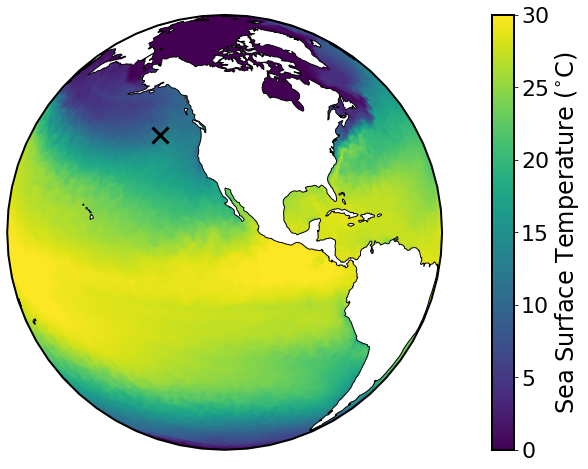

In [78]:
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
fig = plt.figure(figsize=(18,8))

ax = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=245, central_latitude=20.0, globe=None))
plt.gca().patch.set_color('.25')
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# im = plt.contourf(da.lon, da.lat, da.mean('time'), 15, vmin=2, vmax=30, cmap='viridis',transform=ccrs.PlateCarree(), extend='both')
im = plt.pcolormesh(da.lon, da.lat, da.sel(time=('2015-05-01')) , vmin=0, vmax=30, cmap='viridis',transform=ccrs.PlateCarree())
cb = plt.colorbar(im)
cb.set_label(label=r'Sea Surface Temperature ($\rm^{\circ}$C)', size=24)
plt.plot(da.lon.sel(lon=220.125), da.lat.sel(lat=45.125), 'xk', ms=16, markeredgewidth=3, transform=ccrs.PlateCarree())
ax.set_global();

Zoom in to 2012 through 2016

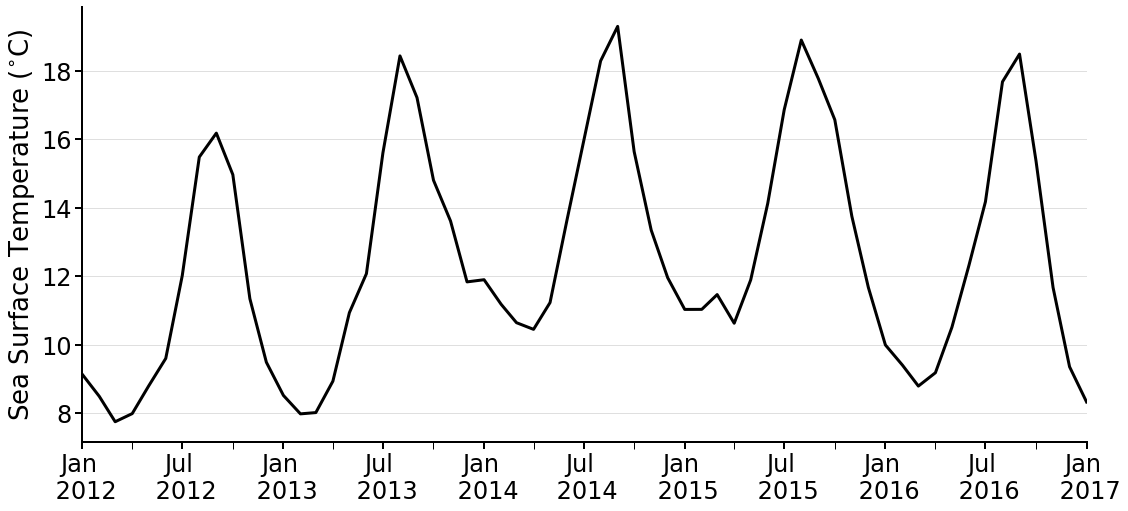

In [122]:
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24)
plt.rcParams['axes.linewidth'] = 2
date_form = DateFormatter("%b \n %Y")

fig = plt.figure(figsize=(18,8)) 
ax = plt.subplot(111)
ax.plot(sst.time.sel(time=slice('2012-01-01', '2017-01-01')), sst.sel(time=slice('2012-01-01', '2017-01-01')), '-k', linewidth=3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(which='major', width=2, length=7)
ax.tick_params(which='minor', width=1, length=4)
plt.xlim(sst.time.sel(time='2012-01-01').values, sst.time.sel(time='2017-01-01').values)
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
ax.tick_params(which='major', width=2, length=7); ax.tick_params(which='minor', width=1, length=7)
ax.yaxis.grid(alpha=0.5)
plt.ylabel(r'Sea Surface Temperature ($ \rm ^{\circ} C$)', fontsize=26);

Plot SST with the mean, seasonal, and trend times series

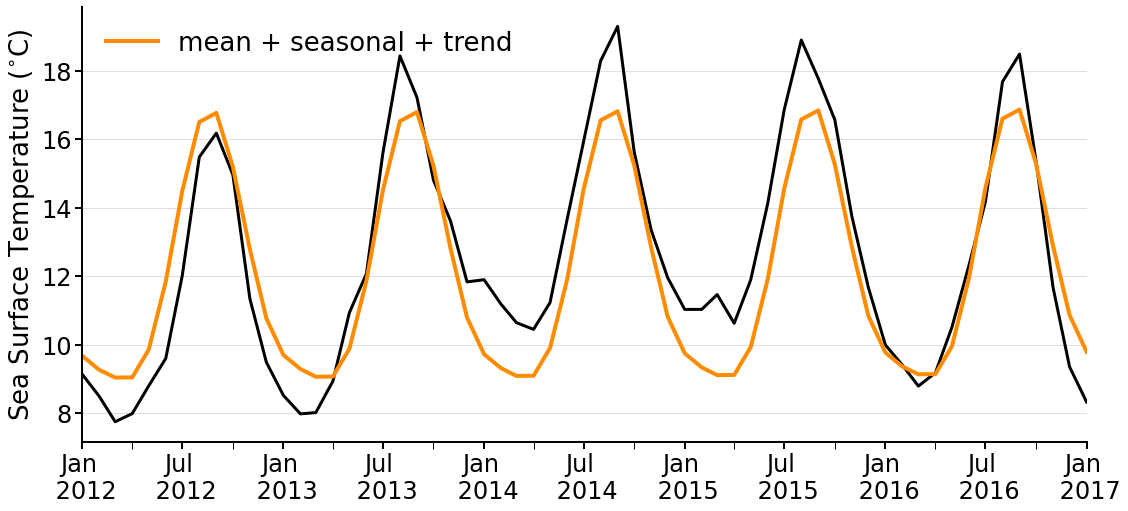

In [143]:
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24)
plt.rcParams['axes.linewidth'] = 2
date_form = DateFormatter("%b \n %Y")

fig = plt.figure(figsize=(18,8)) 
ax = plt.subplot(111)
ax.plot(sst.time.sel(time=slice('2012-01-01', '2017-01-01')), sst.sel(time=slice('2012-01-01', '2017-01-01')), '-k', linewidth=3)
ax.plot(fit.time.sel(time=slice('2012-01-01', '2017-01-01')), fit.sel(time=slice('2012-01-01', '2017-01-01')), '-', color='darkorange', linewidth=4, label='mean + seasonal + trend')
plt.legend(fontsize=26, frameon=False, loc='upper left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(which='major', width=2, length=7)
ax.tick_params(which='minor', width=1, length=4)
plt.xlim(sst.time.sel(time='2012-01-01').values, sst.time.sel(time='2017-01-01').values)
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
ax.tick_params(which='major', width=2, length=7); ax.tick_params(which='minor', width=1, length=7)
ax.yaxis.grid(alpha=0.5)
plt.ylabel(r'Sea Surface Temperature ($ \rm ^{\circ} C$)', fontsize=26);

Remove the mean, seasonal, and trend and show anomalies

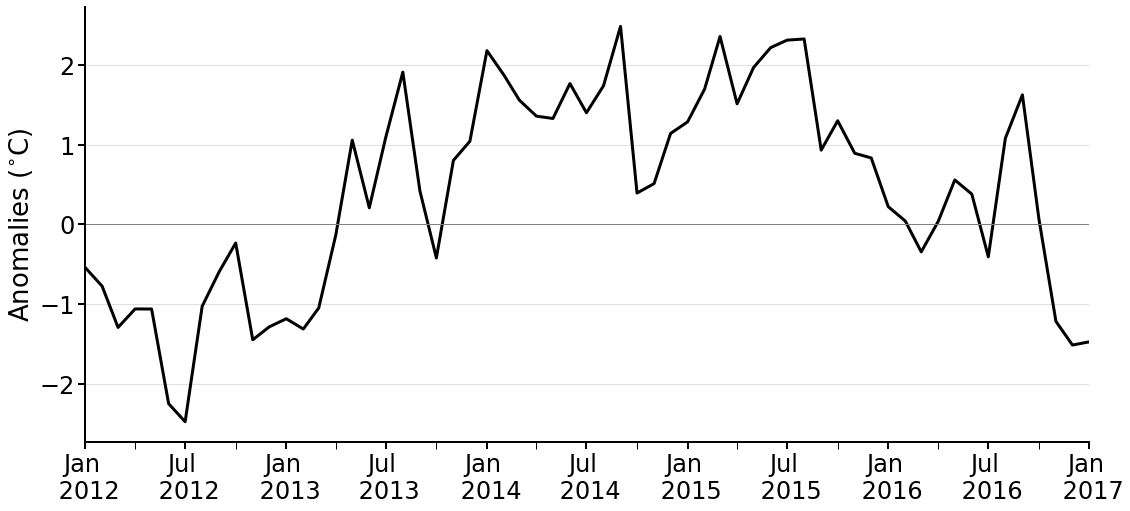

In [157]:
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24)
plt.rcParams['axes.linewidth'] = 2
date_form = DateFormatter("%b \n %Y")

fig = plt.figure(figsize=(18,8)) 
ax = plt.subplot(111)
ax.plot(ssta_notrend.time.sel(time=slice('2012-01-01', '2017-01-01')), ssta_notrend.sel(time=slice('2012-01-01', '2017-01-01')), '-', color='k', linewidth=3)
ax.axhline(0, color='grey', linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(which='major', width=2, length=7)
ax.tick_params(which='minor', width=1, length=4)
plt.xlim(sst.time.sel(time='2012-01-01').values, sst.time.sel(time='2017-01-01').values)
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
ax.tick_params(which='major', width=2, length=7); ax.tick_params(which='minor', width=1, length=7)
ax.yaxis.grid(alpha=0.5)
plt.ylabel(r'Anomalies ($ \rm ^{\circ} C$)', fontsize=26);


Plot 90th percentile

In [160]:
p95 = ssta_notrend.quantile(.95, dim='time', skipna=True)
p99 = ssta_notrend.quantile(.99, dim='time', skipna=True)
mhw = ssta_notrend.where(ssta_notrend>prct_notrend, other=prct_notrend)

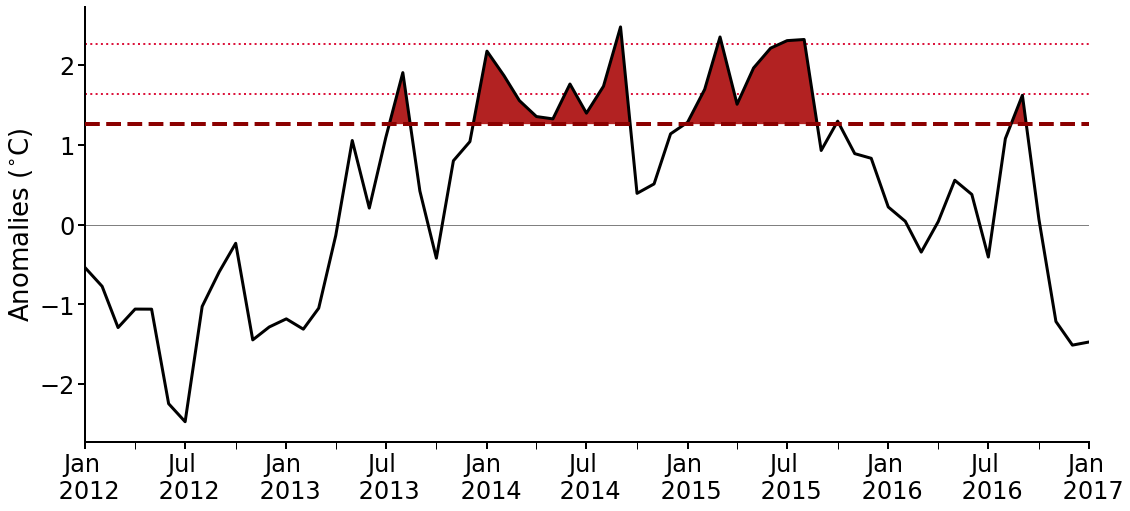

In [246]:
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24)
plt.rcParams['axes.linewidth'] = 2
date_form = DateFormatter("%b \n %Y")

fig = plt.figure(figsize=(18,8)) 
ax = plt.subplot(111)
ax.plot(ssta_notrend.time.sel(time=slice('2012-01-01', '2017-01-01')), ssta_notrend.sel(time=slice('2012-01-01', '2017-01-01')), '-', color='k', linewidth=3, zorder=7)
ax.fill_between(ssta_notrend.time.values, prct_notrend, ssta_notrend, where=ssta_notrend >= prct_notrend,
                 facecolor='firebrick', interpolate=True, zorder=6)
ax.axhline(0, color='grey', linewidth=1)
ax.axhline(p95.values, color='crimson', linestyle=':', linewidth=2)
ax.axhline(p99.values, color='crimson', linestyle=':', linewidth=2)
ax.axhline(prct_notrend.values, color='darkred', linestyle='--', linewidth=4, zorder=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(which='major', width=2, length=7)
ax.tick_params(which='minor', width=1, length=4)
plt.xlim(sst.time.sel(time='2012-01-01').values, sst.time.sel(time='2017-01-01').values)
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
ax.tick_params(which='major', width=2, length=7); ax.tick_params(which='minor', width=1, length=7)
# ax.yaxis.grid(alpha=0.5, zorder=0)
plt.ylabel(r'Anomalies ($ \rm ^{\circ} C$)', fontsize=26);


Make plot again except for entire time series

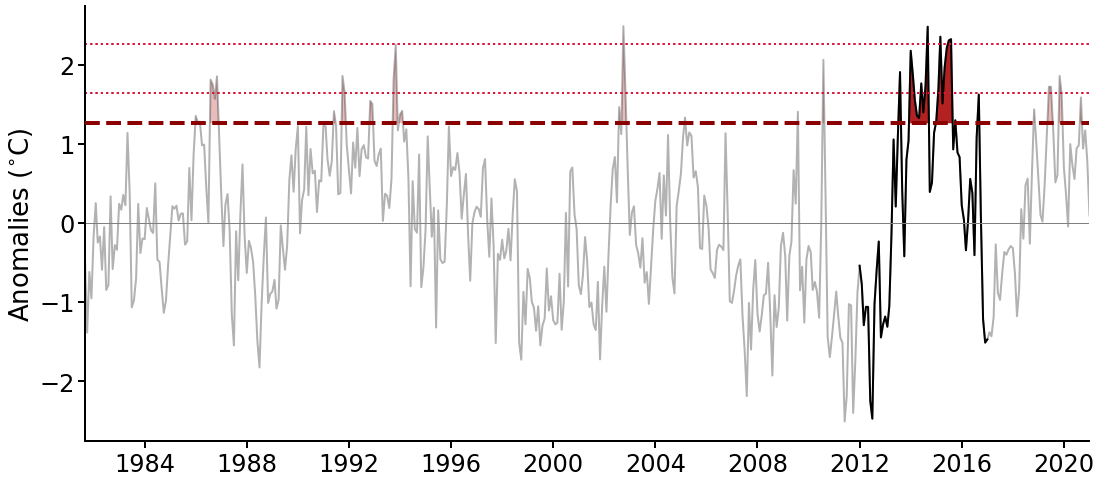

In [340]:
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24)
plt.rcParams['axes.linewidth'] = 2
date_form = DateFormatter("%b \n %Y")

fig = plt.figure(figsize=(18,8)) 
ax = plt.subplot(111)
ax.axhline(0, color='grey', linewidth=1)
ax.axhline(p95.values, color='crimson', linestyle=':', linewidth=2)
ax.axhline(p99.values, color='crimson', linestyle=':', linewidth=2)

ax.plot(ssta_notrend.time, ssta_notrend, '-', color='k', linewidth=2, alpha=0.3)
ax.fill_between(ssta_notrend.time.values, prct_notrend, ssta_notrend, where=ssta_notrend >= prct_notrend,
                 facecolor='firebrick', interpolate=True, alpha=0.3)

ax.plot(ssta_notrend.time.sel(time=slice('2012-01-01', '2017-01-01')), ssta_notrend.sel(time=slice('2012-01-01', '2017-01-01')), '-', color='k', linewidth=2)
ax.fill_between(ssta_notrend.time.sel(time=slice('2012-01-01', '2017-01-01')).values, prct_notrend, ssta_notrend.sel(time=slice('2012-01-01', '2017-01-01')), where=ssta_notrend.sel(time=slice('2012-01-01', '2017-01-01')) >= prct_notrend,
                 facecolor='firebrick', interpolate=True)

ax.axhline(0, color='grey', linewidth=1)
ax.axhline(p95.values, color='crimson', linestyle=':', linewidth=2)
ax.axhline(p99.values, color='crimson', linestyle=':', linewidth=2)
ax.axhline(prct_notrend.values, color='darkred', linestyle='--', linewidth=4, zorder=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(which='major', width=2, length=7)
ax.tick_params(which='minor', width=1, length=4)
# plt.xlim(sst.time.sel(time='2012-01-01').values, sst.time.sel(time='2017-01-01').values)
# ax.xaxis.set_major_formatter(date_form)
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=59))
# ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=12))
ax.tick_params(which='major', width=2, length=7); ax.tick_params(which='minor', width=1, length=7)
plt.xlim(sst.time[0].values, sst.time[-1].values)
plt.ylabel(r'Anomalies ($ \rm ^{\circ} C$)', fontsize=26);


Plot Marine Heatwave metrics

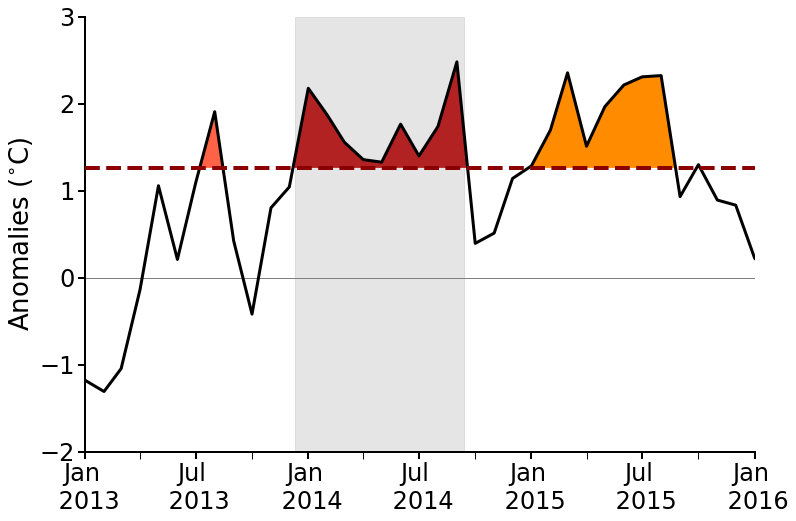

In [245]:
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24)
plt.rcParams['axes.linewidth'] = 2
date_form = DateFormatter("%b \n %Y")

fig = plt.figure(figsize=(12,8)) 
ax = plt.subplot(111)
ax.plot(ssta_notrend.time.sel(time=slice('2012-01-01', '2017-01-01')), ssta_notrend.sel(time=slice('2012-01-01', '2017-01-01')), '-', color='k', linewidth=3, zorder=7)
ax.fill_between(ssta_notrend.time.sel(time=slice('2012-01-01', '2013-09-01')).values, prct_notrend, ssta_notrend.sel(time=slice('2012-01-01', '2013-09-01')).values, 
                where=ssta_notrend.sel(time=slice('2012-01-01', '2013-09-01')).values >= prct_notrend.values,
                facecolor='tomato', interpolate=True, zorder=6)
ax.fill_between(ssta_notrend.time.sel(time=slice('2013-09-01', '2014-10-01')).values, prct_notrend, ssta_notrend.sel(time=slice('2013-09-01', '2014-10-01')).values, 
                where=ssta_notrend.sel(time=slice('2013-09-01', '2014-10-01')).values >= prct_notrend.values,
                facecolor='firebrick', interpolate=True, zorder=6)
ax.fill_between(ssta_notrend.time.sel(time=slice('2014-12-01', '2016-01-01')).values, prct_notrend, ssta_notrend.sel(time=slice('2014-12-01', '2016-01-01')).values, 
                where=ssta_notrend.sel(time=slice('2014-12-01', '2016-01-01')).values >= prct_notrend.values,
                facecolor='darkorange', interpolate=True, zorder=6)
ax.axvspan('2013-12-10','2014-09-12', alpha=0.2, color='grey')
ax.axhline(0, color='grey', linewidth=1)
ax.axhline(prct_notrend.values, color='darkred', linestyle='--', linewidth=4, zorder=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(which='major', width=2, length=7)
ax.tick_params(which='minor', width=1, length=4)
plt.xlim(sst.time.sel(time='2013-01-01').values, sst.time.sel(time='2016-01-01').values)
plt.ylim(-2, 3)
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
ax.tick_params(which='major', width=2, length=7); ax.tick_params(which='minor', width=1, length=7)
# ax.yaxis.grid(alpha=0.5, zorder=0)
plt.ylabel(r'Anomalies ($ \rm ^{\circ} C$)', fontsize=26);


Plot evolution of MHW maps

In [275]:
maps = da#.sel(lon=slice(190.125,245.125), lat=slice(30.125, 60.125))

Now fit mean, trend, annual, and semi-annual harmonics to the SST maps over entire record¶

In [276]:
# Our 6 coefficient model is composed of the mean, trend, annual sine and cosine harmonics, & semi-annual sine and cosine harmonics
model = np.array([np.ones(len(dyr))] + [dyr-np.mean(dyr)] + [np.sin(2*np.pi*dyr)] + [np.cos(2*np.pi*dyr)] + [np.sin(4*np.pi*dyr)] + [np.cos(4*np.pi*dyr)])

# Take the pseudo-inverse of model to 'solve' least-squares problem
pmodel = np.linalg.pinv(model)

# Convert model and pmodel to xaray DataArray
model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':maps.time.values, 'coeff':np.arange(1,7,1)}) 
pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':np.arange(1,7,1), 'time':maps.time.values})  

# resulting coefficients of the model
sst_mod = xr.DataArray(pmodel_da.dot(maps), dims=['coeff','lat','lon'], coords={'coeff':np.arange(1,7,1), 'lat':maps.lat.values, 'lon':maps.lon.values})  

# Construction of the mean, trend, and seasonal cycle
mean = xr.DataArray(model_da[:,0].dot(sst_mod[0,:,:]), dims=['time','lat','lon'], coords={'time':maps.time, 'lat':maps.lat.values, 'lon':maps.lon.values})   
trend = xr.DataArray(model_da[:,1].dot(sst_mod[1,:,:]), dims=['time','lat','lon'], coords={'time':maps.time, 'lat':maps.lat.values, 'lon':maps.lon.values})    
seas = xr.DataArray(model_da[:,2:].dot(sst_mod[2:,:,:]), dims=['time','lat','lon'], coords={'time':maps.time, 'lat':maps.lat.values, 'lon':maps.lon.values})

In [277]:
maps_notrend = xr.DataArray((maps-trend).values, dims=['time','lat','lon'], coords={'time':maps.time, 'lat':maps.lat.values, 'lon':maps.lon.values})  
maps_notrend = xr.DataArray((maps.values-model_da.dot(sst_mod)).values, dims=['time','lat','lon'], coords={'time':maps.time, 'lat':maps.lat.values, 'lon':maps.lon.values}) 


In [278]:
# Define extreme threshold as the 90th percentile
thresh = .9

# Compute values of the monthly threshold
prct_maps = maps_notrend.quantile(thresh, dim='time', skipna=True)


/glade/u/home/scanh/miniconda3/envs/marine-heatwaves/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [279]:
# Take only the SSTa that exceeds the calculated monthly threshold
mhw_ssta_maps = maps_notrend.where(maps_notrend>prct_maps)


In [286]:
mhw_ssta_maps = mhw_ssta_maps.sel(time=slice('2013-01-01', '2016-01-01'))


Plot maps of MHW anomalies

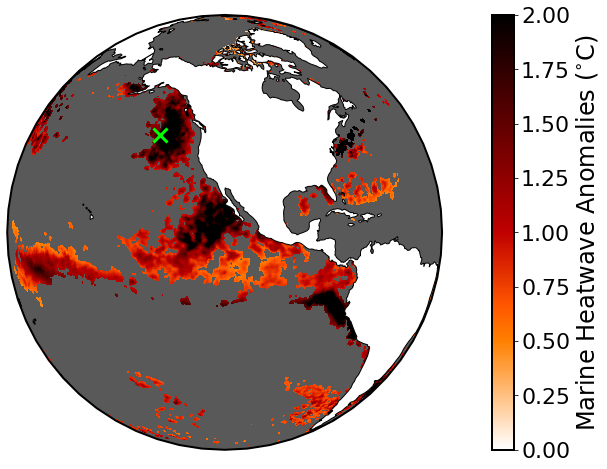

In [299]:
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
fig = plt.figure(figsize=(18,8))

ax = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=245, central_latitude=20.0, globe=None))
plt.gca().patch.set_color('.35')
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
im = plt.pcolormesh(mhw_ssta_maps.lon, mhw_ssta_maps.lat, mhw_ssta_maps.sel(time=('2015-05-01')) , vmin=0, vmax=2, cmap='gist_heat_r',transform=ccrs.PlateCarree())
plt.plot(mhw_ssta_maps.lon.sel(lon=220.125), mhw_ssta_maps.lat.sel(lat=45.125), 'x', color='lime', ms=14, markeredgewidth=3, transform=ccrs.PlateCarree())
cb = plt.colorbar(im)
cb.set_label(label=r'Marine Heatwave Anomalies ($\rm^{\circ}$C)', size=24)
ax.set_global();


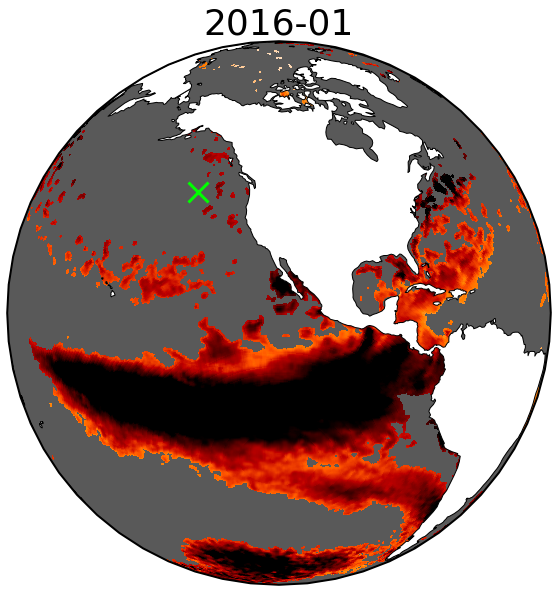

In [312]:
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
fig = plt.figure(figsize=(12,10)) 
plt.rcParams['animation.ffmpeg_path'] = '/glade/u/apps/dav/opt/ffmpeg/4.1.3/gnu/8.3.0/bin/ffmpeg'
plt.rcParams['animation.embed_limit'] = 2**128

ax = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=245, central_latitude=20.0, globe=None))
plt.gca().patch.set_color('.35')
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=1) 
im = plt.pcolormesh(mhw_ssta_maps.lon, mhw_ssta_maps.lat, mhw_ssta_maps[0,:,:], vmin=0, vmax=2, cmap='gist_heat_r',transform=ccrs.PlateCarree())
plt.plot(mhw_ssta_maps.lon.sel(lon=220.125), mhw_ssta_maps.lat.sel(lat=45.125), 'x', color='lime', ms=14, markeredgewidth=3, transform=ccrs.PlateCarree())
cb = plt.colorbar(im); cb.set_label(label=r'Marine Heatwave Anomalies ($\rm^{\circ}$C)', size=24)
ax.set_global();ax.clear()

def animate(i):
        ax = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=245, central_latitude=20.0, globe=None)); ax.clear()
        plt.gca().patch.set_color('.35')
        ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=1) 
        im = plt.pcolormesh(mhw_ssta_maps.lon, mhw_ssta_maps.lat, mhw_ssta_maps[i,:,:], vmin=0, vmax=2, cmap='gist_heat_r',transform=ccrs.PlateCarree())
        plt.plot(mhw_ssta_maps.lon.sel(lon=220.125), mhw_ssta_maps.lat.sel(lat=45.125), 'x', color='lime', ms=20, markeredgewidth=3, transform=ccrs.PlateCarree())
        plt.title(str(mhw_ssta_maps.time[i].dt.strftime('%Y-%m').values), fontsize=36)
        ax.set_global()

anim = animation.FuncAnimation(fig, animate, frames=mhw_ssta_maps.shape[0])

# # Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, bitrate=1800)
outpath = '/glade/u/home/scanh/NCAR-CGD-seminar/movies/NorthPacific_MHWs.mp4'
anim.save(outpath, writer=writer, dpi=300)

HTML(anim.to_jshtml())


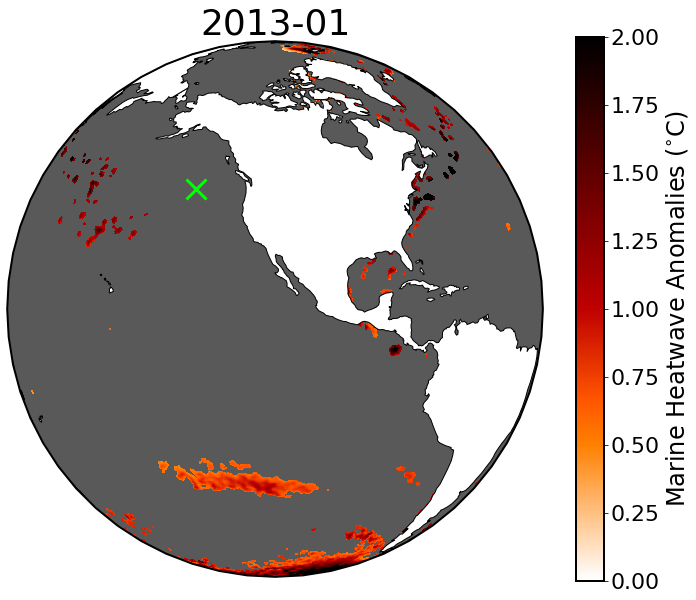

In [311]:
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
fig = plt.figure(figsize=(12,10)) 

ax = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=245, central_latitude=20.0, globe=None))
plt.gca().patch.set_color('.35')
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=1) 
im = plt.pcolormesh(mhw_ssta_maps.lon, mhw_ssta_maps.lat, mhw_ssta_maps[0,:,:], vmin=0, vmax=2, cmap='gist_heat_r',transform=ccrs.PlateCarree())
plt.plot(mhw_ssta_maps.lon.sel(lon=220.125), mhw_ssta_maps.lat.sel(lat=45.125), 'x', color='lime', ms=20, markeredgewidth=3, transform=ccrs.PlateCarree())
cb = plt.colorbar(im); cb.set_label(label=r'Marine Heatwave Anomalies ($\rm^{\circ}$C)', size=24)
plt.title(str(mhw_ssta_maps.time[0].dt.strftime('%Y-%m').values), fontsize=36)
ax.set_global()
